# Usage guide
Copyright: Donghu Guo

Author: Donghu Guo

Description: This is the notebook showing the workflow of how to build, train PredANN and use this model to make normal prediction and DA on one time step and the whole time steps. See the table of contents for a clearer understanding of the structure of this notebook.

Github Repository: https://github.com/ese-msc-2021/irp-dg321

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import joblib

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model

In [3]:
sys.path.append("..")
import tools as t

<IPython.core.display.Javascript object>

In [4]:
root_path = '..data/' # set the root path where data is stored

<IPython.core.display.Javascript object>

## Load data

### Load pod coefficients

In [5]:
# PCA model
pca_compress = joblib.load(root_path + 'Cotrace_fixed_720_npys/train_pca_compress.pkl')
# POD coefficients
X_compressed = joblib.load(root_path + 'Cotrace_fixed_720_npys/train_pod_coefficients.pkl')

scaler_minmax = MinMaxScaler((0,1))
X_compressed = scaler_minmax.fit_transform(X_compressed)

<IPython.core.display.Javascript object>

In [6]:
ncoeffs = X_compressed.shape[1] # number of POD coefficients

<IPython.core.display.Javascript object>

In [7]:
ntimes = 9 # consecutive times for the AAE
step = 1 # step between times
BATCH_SIZE = 32

<IPython.core.display.Javascript object>

In [13]:
data_ct = t.concat_timesteps(X_compressed, ntimes, step)

<IPython.core.display.Javascript object>

In [9]:
learning_rate_nn = 0.0001
learning_rate_d = 0.0005
epochs = 10000
latent_dim = 75

<IPython.core.display.Javascript object>

In [10]:
output_size = ncoeffs

kwargs = {
    "ncoeffs" : ncoeffs,
    "ntimes" : ntimes,
    "step" : step,
    "BATCH_SIZE": BATCH_SIZE,
    "latent_dim": latent_dim,
    "gap_to_plot": gap_to_plot
}

<IPython.core.display.Javascript object>

### train and validation split

In [14]:
# train_ct, test_ct = t.train_test_split(data_ct)
train_ct = data_ct

<IPython.core.display.Javascript object>

In [15]:
# create dataset
train_dataset, X_train_4d = t.create_dataset(train_ct, ncoeffs, ntimes, BATCH_SIZE)
# test_dataset, X_test_4d = t.create_dataset(test_ct, ncoeffs, ntimes, BATCH_SIZE)

2022-08-02 17:08:13.715287: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-02 17:08:14.359543: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9648 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:1b:00.0, compute capability: 7.5


<IPython.core.display.Javascript object>

In [16]:
print(train_dataset.batch)

<bound method DatasetV2.batch of <BatchDataset element_spec=TensorSpec(shape=(None, 9, 550, 1), dtype=tf.float32, name=None)>>


<IPython.core.display.Javascript object>

In [13]:
# # create dataset
# train_dataset, X_train_4d, Y_train_4d = t.create_dataset_ann(train_ct, ncoeffs, ntimes, BATCH_SIZE)
# test_dataset, X_test_4d, Y_test_4d = t.create_dataset_ann(test_ct, ncoeffs, ntimes, BATCH_SIZE)

In [17]:
print(X_train_4d.shape)

(591, 9, 550, 1)


<IPython.core.display.Javascript object>

In [19]:
print(train_ct.shape)
# print(test_ct.shape)

(591, 9, 550)


<IPython.core.display.Javascript object>

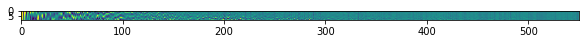

<IPython.core.display.Javascript object>

In [20]:
plt.figure(figsize=(10,10))
plt.imshow(X_train_4d[0,:,:,0])

In [17]:
Y_train = X_train_4d[:,-1,:,:].reshape(X_train_4d.shape[0],1,X_train_4d.shape[2],X_train_4d.shape[3])
X_train = X_train_4d[:,:-1,:,:]

(90, 8, 100, 1)


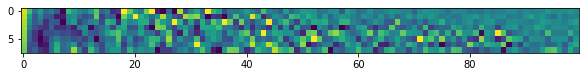

In [23]:
plt.figure(figsize=(10,10))
plt.imshow(X_train[0,:,:,0])
print(X_train.shape)

(90, 1, 100, 1)


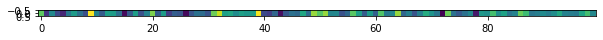

In [24]:
plt.figure(figsize=(10,10))
plt.imshow(Y_train[0,:,:,0])
print(Y_train.shape)

Text(0.5, 0.98, 'train dataset histogram')

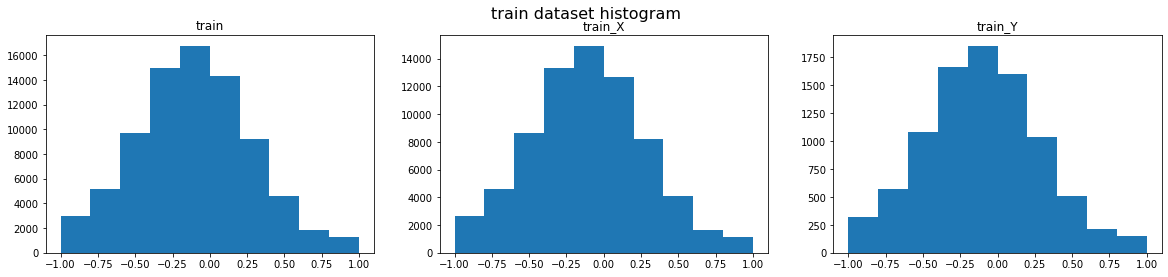

In [25]:
fig, ax = plt.subplots(1,3, figsize=[20,4])
ax.flatten()[0].hist(X_train_4d.flatten())
ax.flatten()[0].set_title('train')
ax.flatten()[1].hist(X_train.flatten())
ax.flatten()[1].set_title('train_X')
ax.flatten()[2].hist(Y_train.flatten())
ax.flatten()[2].set_title('train_Y')
fig.suptitle('train dataset histogram', fontsize=16)

In [43]:
train_X_dataset = tf.data.Dataset.from_tensor_slices(X_train_4d)
train_X_dataset = train_X_dataset.shuffle(len(X_train_4d))
train_X_dataset = train_X_dataset.batch(BATCH_SIZE)

In [44]:
train_Y_dataset = tf.data.Dataset.from_tensor_slices(Y_train_4d)
train_Y_dataset = train_Y_dataset.shuffle(len(Y_train_4d))
train_Y_dataset = train_Y_dataset.batch(BATCH_SIZE)

In [45]:
# d = tf.data.Dataset.zip((train_X_dataset,train_Y_dataset))
# d = d.map(lambda x,y:tf.concat([x,y],axis=-3))

# it = iter(d)
# x = next(it)
# print(x.shape)
# print(x)

## Build network

In [16]:
# model = t.PredAAE(**kwargs)
# model.make_PredAAE()
# hist,reconstruction = model.train(train_dataset, epochs)

# autoencoder = model.autoencoder
# enc_disc = model.enc_disc

In [26]:
def make_encoder_model():
    model = tf.keras.Sequential()
    model.add(keras.layers.Conv2D(16, (3, 3), strides=(1, 1), padding='same', input_shape=[ntimes-1, ncoeffs, 1]))
    # model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())
    # model.add(keras.layers.Dropout(0.2))

    model.add(keras.layers.Conv2D(8, (3, 3), strides=(1, 1), padding='same'))
    # model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())
    # model.add(keras.layers.Dropout(0.2))

    model.add(keras.layers.Conv2D(4, (3, 3), strides=(1, 1), padding='same'))
    # model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())
    # model.add(keras.layers.Dropout(0.2))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(output_size))
    return model


def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(keras.layers.Dense(240, activation="relu", input_shape=(output_size,)))
    # model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.Dense(120, activation="relu"))
    # model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.Dense(60, activation="relu"))
    # model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.Dense(1))
    return model

In [27]:
encoder = make_encoder_model()
# decoder = make_decoder_model()
discriminator = make_discriminator_model()

autoencoder = keras.models.Sequential([encoder, discriminator])
print(encoder.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 8, 90, 16)         160       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8, 90, 16)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 90, 8)          1160      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 90, 8)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 90, 4)          292       
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 90, 4)          0         
                                                                 
 flatten (Flatten)           (None, 2880)              0

In [28]:
print(discriminator.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 240)               21840     
                                                                 
 dense_2 (Dense)             (None, 120)               28920     
                                                                 
 dense_3 (Dense)             (None, 60)                7260      
                                                                 
 dense_4 (Dense)             (None, 1)                 61        
                                                                 
Total params: 58,081
Trainable params: 58,081
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
mse = tf.keras.losses.MeanSquaredError()

def compute_reconstruction_loss(x, x_logit):
    """
    Calculate mean square error 
    between the input of the encoder 
    and the output of the decoder 
    
    Parameters
    ----------
    x : Tensor 
      the input of the encoder
    x_logit : Tensor
      the output of the decoder

    Returns
    -------
    Tensor
      mean squared loss between x and x_logit
    """  
    reconstruction_loss = mse(x, x_logit)
    return reconstruction_loss

def compute_discriminator_loss(fake_output, real_output):
    """
    Calculate cross entropy loss 
    between random noise and one, 
    the output of the encoder and zero 
    
    Parameters
    ----------
    fake_output : Tensor 
      the result of the discriminator 
      on the output of the encoder 
    real_output : Tensor
      the result of the discriminator 
      on the output of random noise
      
    Returns
    -------
    Tensor
      the discrimination result
      on the output of the encoder and random noise
    """  
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
    
reconstruction_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)
discriminator_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)

r_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_nn)

d_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_d)

# Notice the use of `tf.function` for speeding up calculation
# This annotation causes the function to be "compiled".
@tf.function
def train_step(batch):
    # batch = iter(batch)
    # batch = next(batch)
    batch_X = batch[:,:-1]
    batch_Y = batch[:,-1,:,0]
    # print(batch.shape)
    # print(batch_X.shape)
    # print(batch_Y.shape)
    # NN update
    with tf.GradientTape() as ae_tape:
        encoder_output = encoder(batch_X, training=True)
        # decoder_output = decoder(encoder_output, training=True)
        reconstruction_loss = compute_reconstruction_loss(batch_Y, encoder_output)

    r_gradients = ae_tape.gradient(reconstruction_loss, encoder.trainable_variables)
    r_optimizer.apply_gradients(zip(r_gradients, encoder.trainable_variables))

    # Discriminator update
    with tf.GradientTape() as d_tape:
        z = encoder(batch_X, training=True)
        true_z = batch_Y   # tf.random.normal(shape=(z.shape))
        fake_output = discriminator(z, training=True)
        true_output = discriminator(true_z, training=True)
        discriminator_loss = compute_discriminator_loss(fake_output, true_output)
    d_gradients = d_tape.gradient(discriminator_loss, discriminator.trainable_variables)
    d_optimizer.apply_gradients(zip(d_gradients, discriminator.trainable_variables))

    # # Generator update
    # with tf.GradientTape() as g_tape:
    #     z = encoder(batch, training=True)
    #     fake_output = discriminator(z, training=True)
    #     generator_loss = compute_generator_loss(fake_output)
    # g_gradients = g_tape.gradient(generator_loss, encoder.trainable_variables)
    # g_optimizer.apply_gradients(zip(g_gradients, encoder.trainable_variables))

    reconstruction_mean_loss(reconstruction_loss)
    # generator_mean_loss(generator_loss)
    discriminator_mean_loss(discriminator_loss)

def train(dataset, epochs):
    hist = []
    reconstruction = []
    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch + 1, epochs))
        # train_X_dataset, train_Y_dataset = dataset   
        for batch in dataset:
            # print(batch.size)
            train_step(batch)

        hist.append([reconstruction_mean_loss.result().numpy(), discriminator_mean_loss.result().numpy()])
        reconstruction.append(reconstruction_mean_loss.result().numpy())

        # Resets all of the metric state variables.
        # This function is called between epochs/steps, when a metric is evaluated during training.
        # generator_mean_loss.reset_states()
        discriminator_mean_loss.reset_states()
        reconstruction_mean_loss.reset_states()
        
        # if epoch > 0 and epoch%10 == 0:
        #     # Plot loss
        #     print('Loss: ')
        #     fig, ax = plt.subplots(1,1, figsize=[20,10])
        #     ax.plot(hist)
        #     ax.legend(['loss_gen', 'loss_disc'])
        #     #ax.set_yscale('log')
        #     ax.grid()
        #     plt.show()
         
    return hist, reconstruction
    

hist,reconstruction = train(train_dataset, epochs=epochs)

# save trained model
autoencoder.save(root_path + 'models/anns/ann_train_n{}_e{}_s{}.h5'.format(ntimes, epochs, step))
# enc_disc.save(root_path + 'models/enc_disc_n{}_e{}_s{}.h5'.format(ntimes, epochs, step))

In [15]:
# Reconstruction loss of the last epoch
reconstruction[-1]

2.307746e-05

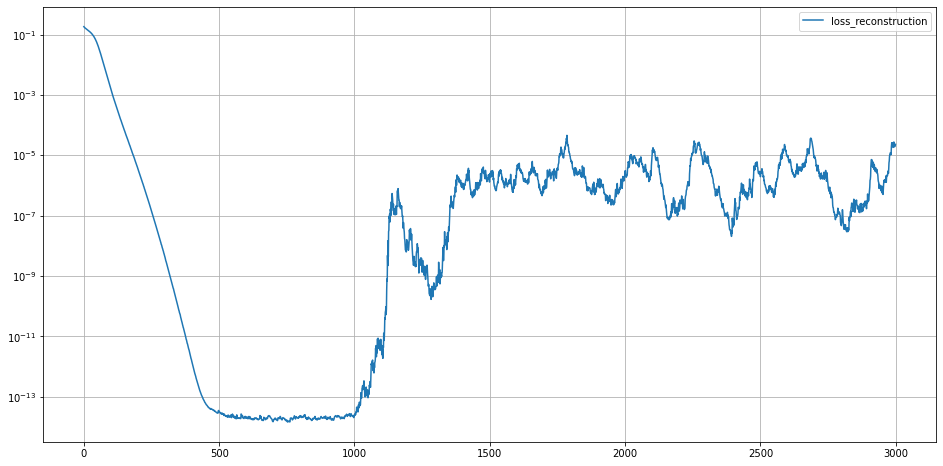

In [16]:
fig, ax = plt.subplots(1,1, figsize=[16,8])
ax.plot(reconstruction)
ax.legend(['loss_reconstruction'])
ax.set_yscale('log')
ax.grid()

In [17]:
# Generation loss and discrimination loss of the last epoch
hist[-1]

[2.307746e-05, 1.3853607]

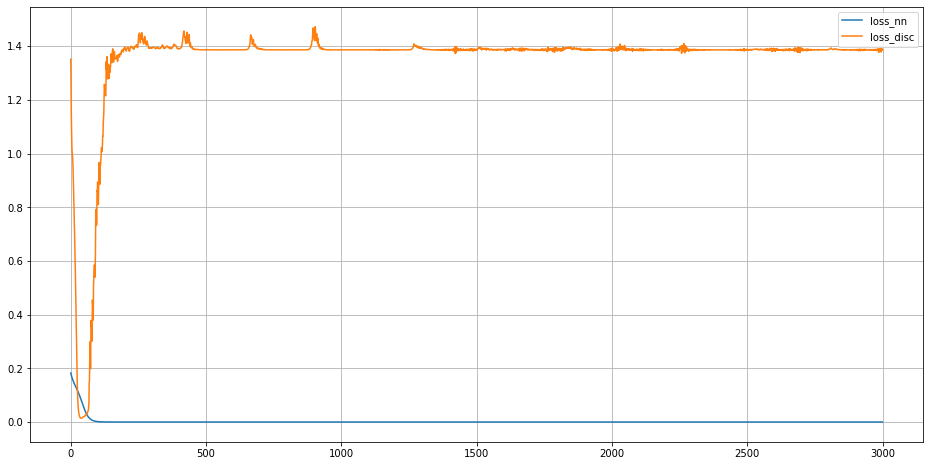

In [18]:
fig, ax = plt.subplots(1,1, figsize=[16,8])
ax.plot(hist)
ax.legend(['loss_nn', 'loss_disc'])
#ax.set_yscale('log')
ax.grid()

## Test the reconstruction performance of autoencoder

In [21]:
nn = load_model(root_path + 'Cotrace_fixed_720_models/ann_train_n{}_e{}_s{}.h5'.format(ntimes, epochs, step)).layers
# X_train_concat = X_train_4d
# codings_size = X_compressed.shape[1]


<IPython.core.display.Javascript object>

### train set

In [22]:
print(X_train_4d.shape)

(591, 9, 550, 1)


<IPython.core.display.Javascript object>

In [ ]:
sample_i = 28
Y_pred = nn.predict(X_train_4d[sample_i][:-1].reshape((1, ntimes-1, train_ct.shape[2], 1)))
print(Y_pred.shape)
# X_recon = X_recon.reshape(ntimes,ncoeffs)
Y_real = X_train_4d[sample_i][-1:].reshape(1,ncoeffs)

real = X_train_4d[sample_i].reshape(ntimes,ncoeffs)
print(real.shape)
pred = real.copy()
pred[-1] = Y_pred

fig, ax = plt.subplots(2,5, figsize=[20,8])
for i in range(10):
    # ax.flatten()[i].plot(X_pred[:,i], '-o')
    # ax.flatten()[i].plot(X_real[:,i], '-o')
    ax.flatten()[i].plot(pred[:,i], '-o')
    ax.flatten()[i].plot(real[:,i], '-o')
    ax.flatten()[i].legend(['recon', 'ground true'])

In [28]:
sample_i = 28
X_pred = nn.predict(X_train_4d[sample_i][:-1].reshape((1, ntimes-1, train_ct.shape[2], 1)))
print(X_pred.shape)
# X_recon = X_recon.reshape(ntimes,ncoeffs)
X_real = X_train_4d[sample_i][-1:].reshape(1,ncoeffs)



1/1 [==============================] - 0s 19ms/step
(1, 100)


(1, 100)


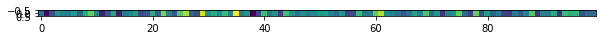

In [73]:
plt.figure(figsize=(10,10))
plt.imshow(X_pred)
print(X_pred.shape)

(1, 100)


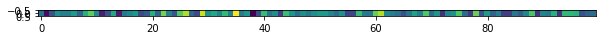

In [74]:
plt.figure(figsize=(10,10))
plt.imshow(X_real)
print(X_real.shape)

(1, 100)


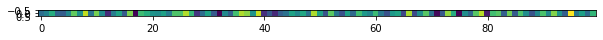

In [75]:
plt.figure(figsize=(10,10))
plt.imshow(X_real-X_pred)
print(X_real.shape)

### test set

1/1 [==============================] - 0s 18ms/step
(1, 100)
(9, 100)


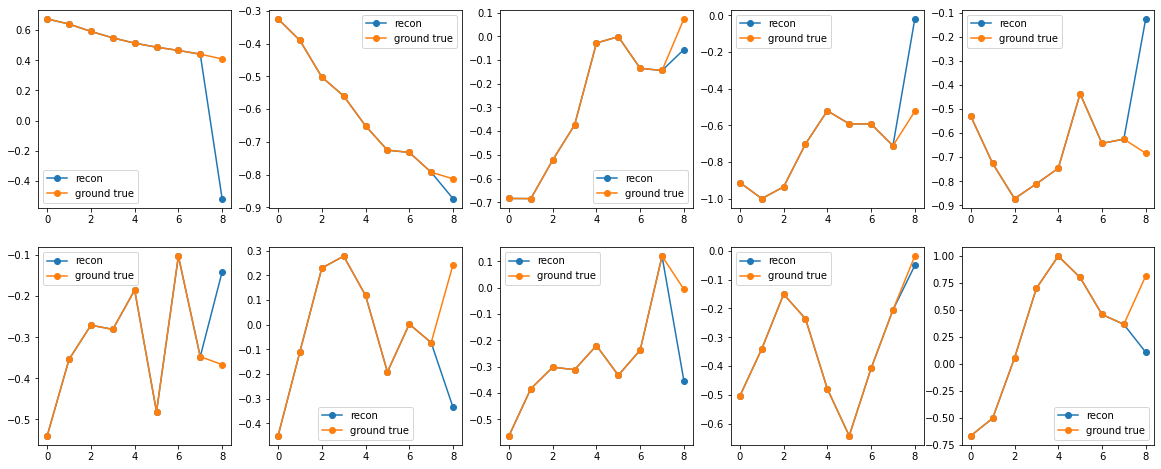

In [29]:
sample_i = 2

Y_pred = nn.predict(X_test_4d[sample_i][:-1].reshape((1, ntimes-1, test_ct.shape[2], 1)))
print(X_pred.shape)
# X_recon = X_recon.reshape(ntimes,ncoeffs)
Y_real = X_test_4d[sample_i][-1:].reshape(1,ncoeffs)

real = X_test_4d[sample_i].reshape(ntimes,ncoeffs)
print(real.shape)
pred = real.copy()
pred[-1] = Y_pred

fig, ax = plt.subplots(2,5, figsize=[20,8])
for i in range(10):
    # ax.flatten()[i].plot(X_pred[:,i], '-o')
    # ax.flatten()[i].plot(X_real[:,i], '-o')
    ax.flatten()[i].plot(pred[:,i], '-o')
    ax.flatten()[i].plot(real[:,i], '-o')
    ax.flatten()[i].legend(['recon', 'ground true'])

## Prediction procedure

In [19]:
print(X_compressed.shape)

(100, 90)


In [20]:
print(X_train_4d.shape)

(91, 9, 90, 1)


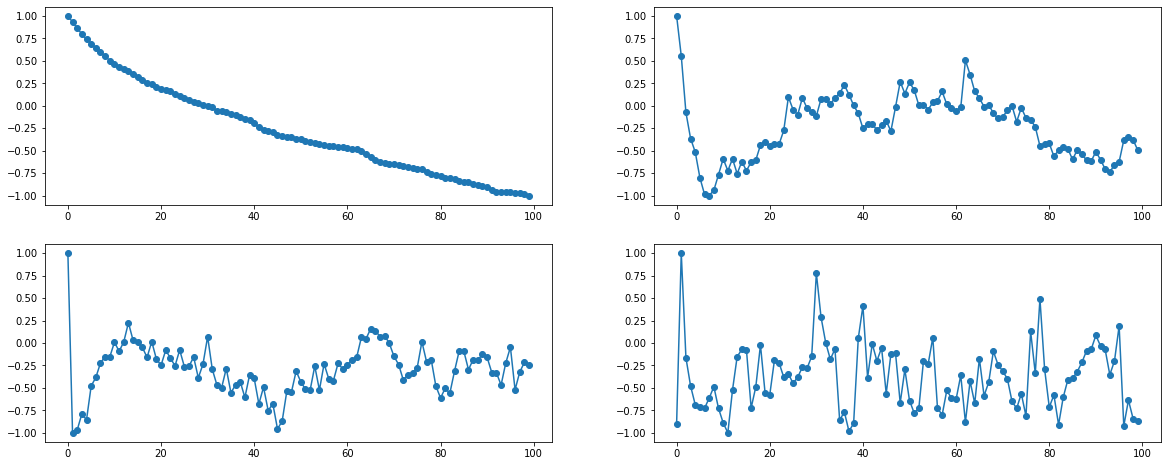

In [21]:
scaler = 3
num_sample = 4

nth_node = 5

fig, ax = plt.subplots(2,2, figsize=[20,8])
for i in range(num_sample ):

    ax.flatten()[i].plot(X_compressed[:,i*scaler], '-o')

In [ ]:
X_train_4d[sample_i][:-1].reshape((1, ntimes-1, train_ct.shape[2], 1))

In [34]:
nn = autoencoder

1/1 [==============================] - 0s 18ms/step


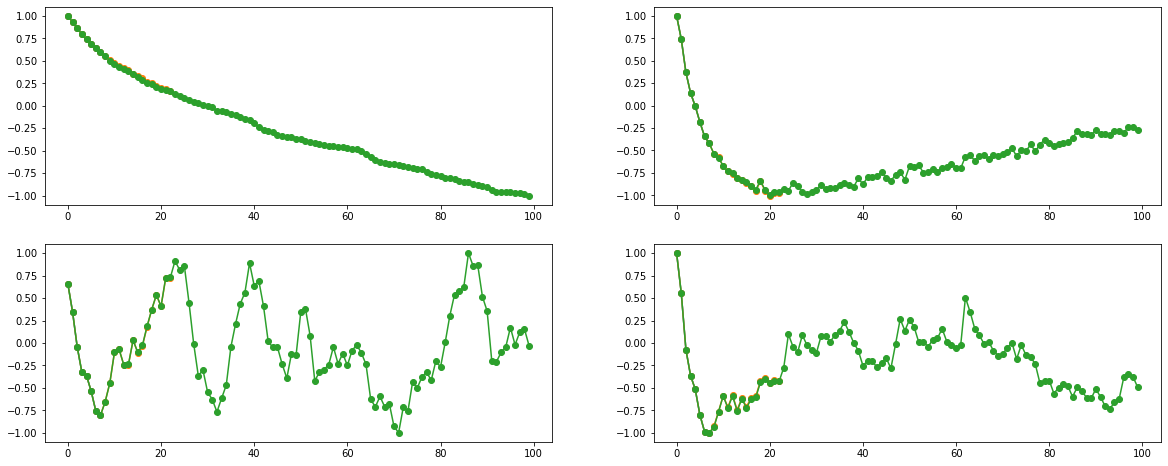

In [26]:
ann = nn

t_start = 0
prediction_num = 15

scaler = 1
num_sample = 4

nth_node = 5

preds = []
# choose initial input
initial_input = X_compressed[t_start:t_start+ntimes-1,:]
current_input = initial_input.reshape((1, ntimes-1, ncoeffs, 1))
# current_input = tf.data.Dataset.from_tensor_slices(initial_input)
# print(current_input.shape)
for j in range(prediction_num):
    pred = ann.predict(current_input)

    preds.append(pred)
    # print(current_input[:,1:].shape)
    # print(pred.reshape((1, 1, ncoeffs, 1)).shape)

    new_input = np.concatenate((current_input[:,1:], pred.reshape((1, 1, ncoeffs, 1))), axis = 1)

    current_input = new_input
preds = np.array(preds).reshape((prediction_num, ncoeffs))
preds = np.concatenate((initial_input, preds))

fig, ax = plt.subplots(2,2, figsize=[20,8])
for i in range(num_sample):
    

    ax.flatten()[i].plot(initial_input[:, i*scaler], '-o')
    ax.flatten()[i].plot(preds[:, i*scaler], '-o')
    ax.flatten()[i].plot(X_compressed[:,i*scaler], '-o')


1/1 [==============================] - 0s 18ms/step
(8, 90)
(100, 90)


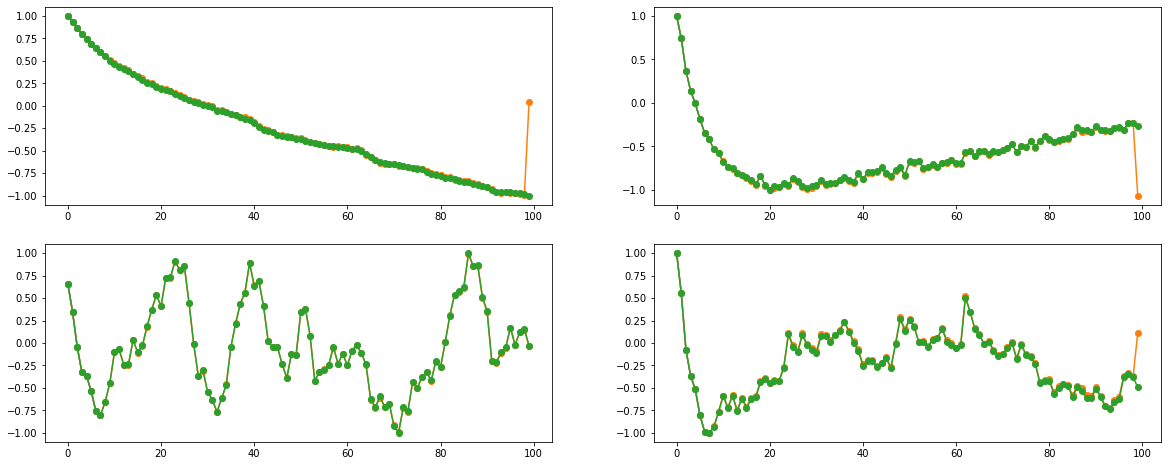

In [27]:
# predict all
ann = nn

t_start = 0
prediction_num = X_compressed.shape[0]-ntimes+1

scaler = 1
num_sample = 4

nth_node = 5

preds = []
# choose initial input
initial_input = X_compressed[t_start:t_start+ntimes-1,:]
current_input = initial_input.reshape((1, ntimes-1, ncoeffs, 1))
# current_input = tf.data.Dataset.from_tensor_slices(initial_input)
# print(current_input.shape)
for j in range(prediction_num):
    pred = ann.predict(current_input)

    preds.append(pred)
    # print(current_input[:,1:].shape)
    # print(pred.reshape((1, 1, ncoeffs, 1)).shape)

    new_input = np.concatenate((current_input[:,1:], pred.reshape((1, 1, ncoeffs, 1))), axis = 1)

    current_input = new_input
preds = np.array(preds).reshape((prediction_num, ncoeffs))
preds = np.concatenate((initial_input, preds))

print(initial_input.shape)
print(preds.shape)
fig, ax = plt.subplots(2,2, figsize=[20,8])
for i in range(num_sample):
    

    ax.flatten()[i].plot(initial_input[:, i*scaler], '-o')
    ax.flatten()[i].plot(preds[:, i*scaler], '-o')
    ax.flatten()[i].plot(X_compressed[:,i*scaler], '-o')

1/1 [==============================] - 0s 17ms/step
(8, 90)
(98, 90)


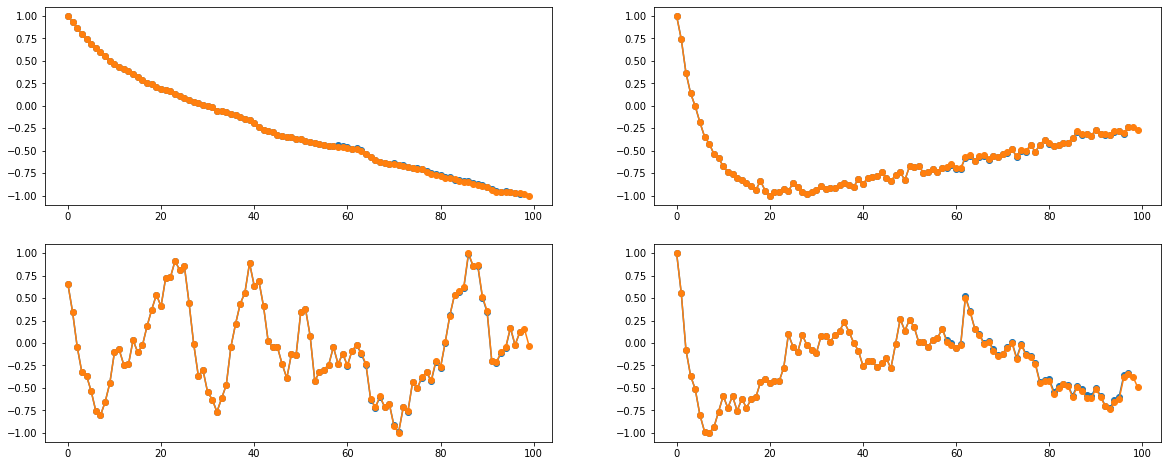

In [28]:
# predict all
ann = nn

t_start = 50
prediction_num = 40

scaler = 1
num_sample = 4

nth_node = 5

preds = []
# choose initial input
initial_input = X_compressed[t_start:t_start+ntimes-1,:]
current_input = initial_input.reshape((1, ntimes-1, ncoeffs, 1))
# current_input = tf.data.Dataset.from_tensor_slices(initial_input)
# print(current_input.shape)
for j in range(prediction_num):
    pred = ann.predict(current_input)

    preds.append(pred)
    # print(current_input[:,1:].shape)
    # print(pred.reshape((1, 1, ncoeffs, 1)).shape)

    new_input = np.concatenate((current_input[:,1:], pred.reshape((1, 1, ncoeffs, 1))), axis = 1)

    current_input = new_input
preds = np.array(preds).reshape((prediction_num, ncoeffs))
preds = np.concatenate((X_compressed[0:t_start+ntimes-1,:], preds))

print(initial_input.shape)
print(preds.shape)
fig, ax = plt.subplots(2,2, figsize=[20,8])
for i in range(num_sample):
    

    # ax.flatten()[i].plot(initial_input[:, i*scaler], '-o')
    ax.flatten()[i].plot(preds[:, i*scaler], '-o')
    ax.flatten()[i].plot(X_compressed[:,i*scaler], '-o')

### Pretict on test data

In [35]:
# test snap matrix
test_all_values = joblib.load(root_path + 'data/toydata/test_snapshot_matrix.pkl')
print(test_all_values.shape)

X_compressed_test = pca_compress.transform(test_all_values)
print(X_compressed_test.shape)

scaler_minmax_test = MinMaxScaler((-1,1))
X_compressed_test = scaler_minmax_test.fit_transform(X_compressed_test)

(20, 1344420)
(20, 90)


1/1 [==============================] - 0s 18ms/step
(8, 90)
(20, 90)


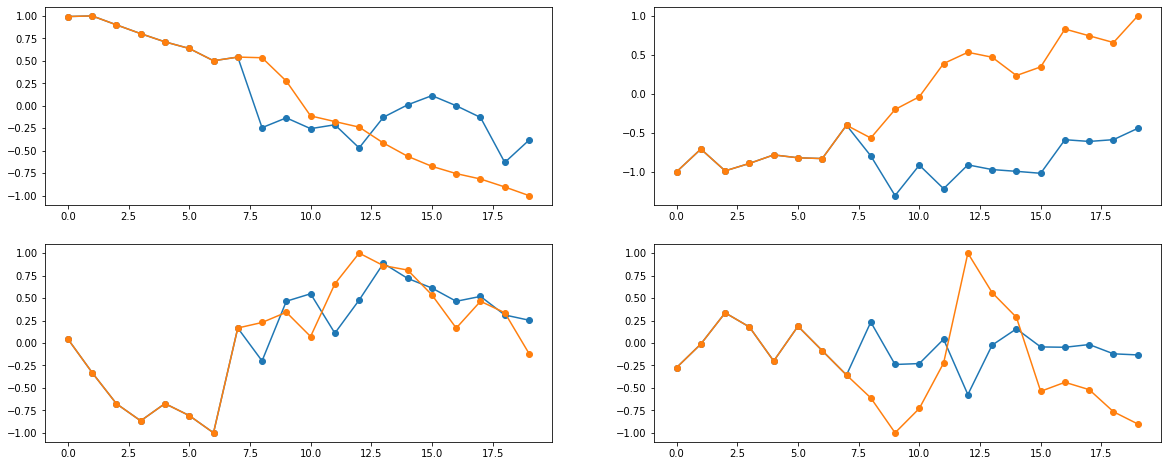

In [36]:
# predict all
ann = nn

t_start = 0
prediction_num = 12

scaler = 1
num_sample = 4

nth_node = 5

preds = []
# choose initial input
initial_input = X_compressed_test[t_start:t_start+ntimes-1,:]
current_input = initial_input.reshape((1, ntimes-1, ncoeffs, 1))
# current_input = tf.data.Dataset.from_tensor_slices(initial_input)
# print(current_input.shape)
for j in range(prediction_num):
    pred = ann.predict(current_input)

    preds.append(pred)
    # print(current_input[:,1:].shape)
    # print(pred.reshape((1, 1, ncoeffs, 1)).shape)

    new_input = np.concatenate((current_input[:,1:], pred.reshape((1, 1, ncoeffs, 1))), axis = 1)

    current_input = new_input
preds = np.array(preds).reshape((prediction_num, ncoeffs))
preds = np.concatenate((X_compressed_test[0:t_start+ntimes-1,:], preds))

print(initial_input.shape)
print(preds.shape)
fig, ax = plt.subplots(2,2, figsize=[20,8])
for i in range(num_sample):
    

    # ax.flatten()[i].plot(initial_input[:, i*scaler], '-o')
    ax.flatten()[i].plot(preds[:, i*scaler], '-o')
    ax.flatten()[i].plot(X_compressed_test[:,i*scaler], '-o')

In [37]:
print(preds.shape)

(20, 90)


In [38]:
preds_scale_inverse = scaler_minmax_test.inverse_transform(preds)

In [40]:
X_compressed_test_scale_inverse = scaler_minmax_test.inverse_transform(X_compressed_test)

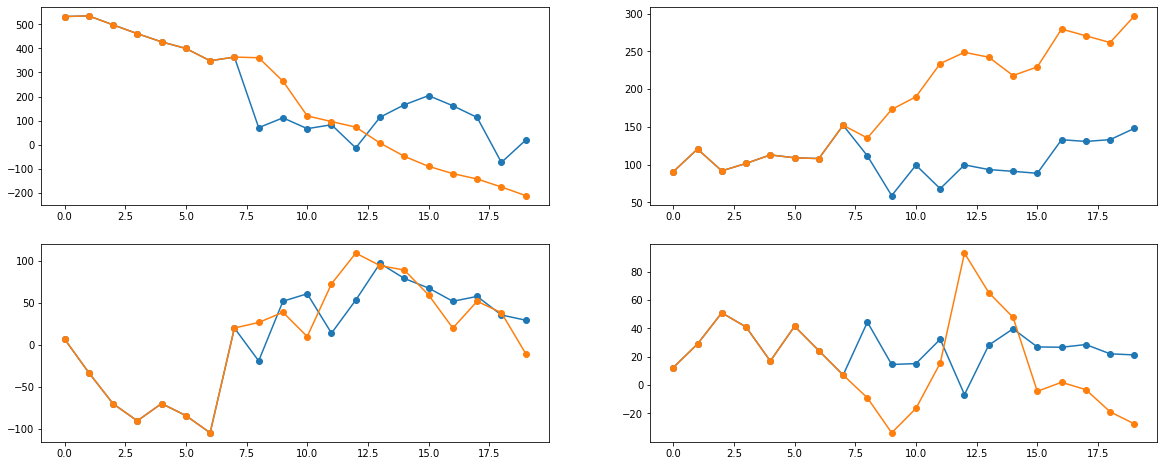

In [41]:
fig, ax = plt.subplots(2,2, figsize=[20,8])
for i in range(num_sample):
    

    # ax.flatten()[i].plot(initial_input[:, i*scaler], '-o')
    ax.flatten()[i].plot(preds_scale_inverse[:, i*scaler], '-o')
    ax.flatten()[i].plot(X_compressed_test_scale_inverse[:,i*scaler], '-o')